# Cabbage Regression Model with SARIMA
By Menard Gymer Rivera

## Load the Dataset

In [51]:
import pandas as pd

In [52]:
Tilapia_UN = pd.read_excel('./data/cabbage_UN.xlsx')

In [53]:
Tilapia_DA = pd.read_excel('./data/cabbage_DA.xlsx')

In [54]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,181,Cabbage - Retail,5,KG,1,2008,34.17
1,181,Cabbage - Retail,5,KG,1,2008,43.77
2,181,Cabbage - Retail,5,KG,1,2008,30.75
3,181,Cabbage - Retail,5,KG,1,2008,40.00
4,181,Cabbage - Retail,5,KG,1,2008,48.91
...,...,...,...,...,...,...,...
2536,181,Cabbage - Retail,5,KG,6,2021,55.00
2537,181,Cabbage - Retail,5,KG,6,2021,61.88
2538,181,Cabbage - Retail,5,KG,6,2021,66.25
2539,181,Cabbage - Retail,5,KG,6,2021,130.00


In [55]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,181.0,Cabbage - Retail,5.0,KG,1,2008,34.17
1,181.0,Cabbage - Retail,5.0,KG,1,2008,43.77
2,181.0,Cabbage - Retail,5.0,KG,1,2008,30.75
3,181.0,Cabbage - Retail,5.0,KG,1,2008,40.00
4,181.0,Cabbage - Retail,5.0,KG,1,2008,48.91


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [56]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [57]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [58]:
Tilapia_UN.head()

,mp_price,date
0,34.17,2008-01-15
1,43.77,2008-01-15
2,30.75,2008-01-15
3,40.00,2008-01-15
4,48.91,2008-01-15


### DA Bantay Presyo

In [59]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [60]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id','cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [61]:
Tilapia_DA.head()

,mp_price,date
0,34.17,2008-01-15
1,43.77,2008-01-15
2,30.75,2008-01-15
3,40.00,2008-01-15
4,48.91,2008-01-15


In [62]:
import matplotlib.pyplot as plt

In [63]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

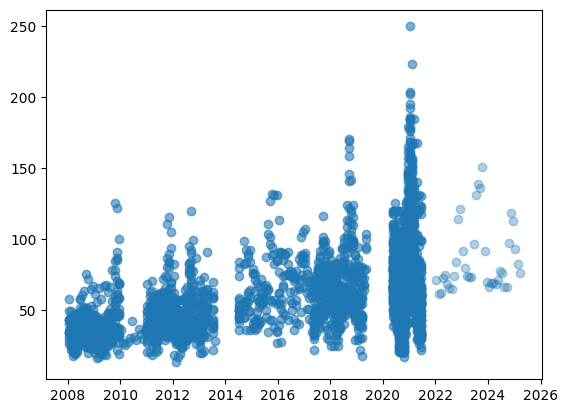

<Figure size 5000x600 with 0 Axes>

In [64]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [65]:
from datetime import datetime

In [66]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [67]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [68]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [69]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2008-01-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [70]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

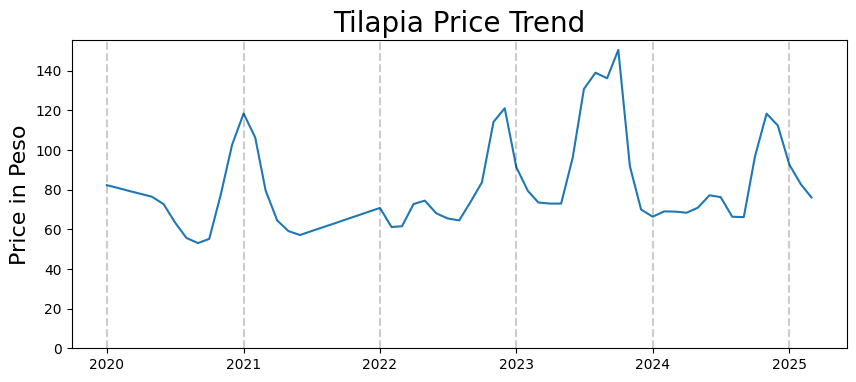

In [71]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [72]:
first_diff = lim_tilapia.diff()[1:]

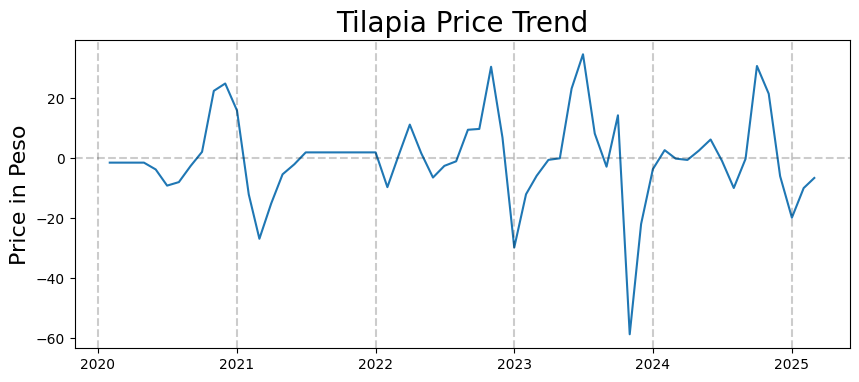

In [73]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [74]:
from statsmodels.tsa.stattools import acf, pacf

In [75]:
first_diff.columns

Index(['mp_price'], dtype='object')

In [76]:
first_diff.head()

,mp_price
date,
2020-02-01,-1.461466
2020-03-01,-1.461466
2020-04-01,-1.461466
2020-05-01,-1.461466
2020-06-01,-3.727383


<BarContainer object of 18 artists>

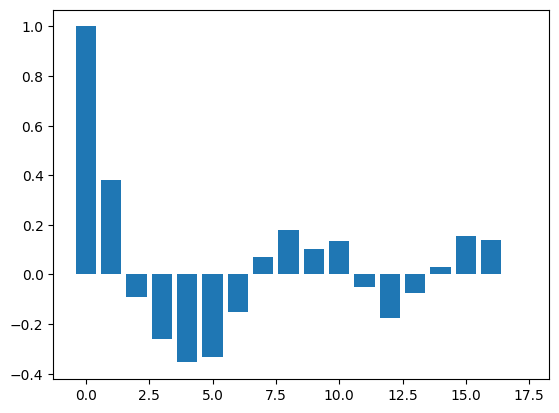

In [77]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

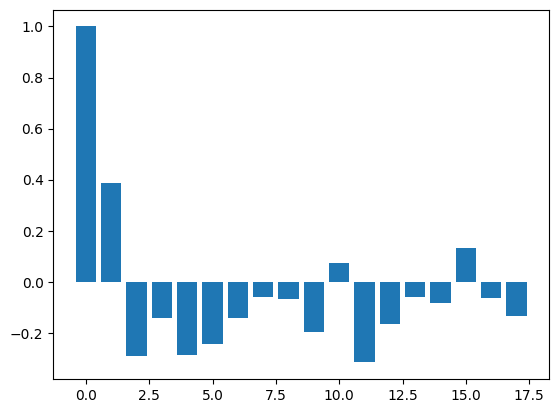

In [78]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [79]:
from datetime import timedelta

In [80]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [81]:
Tilapia.describe()

,mp_price
count,207.000000
mean,61.751077
std,23.042587
min,25.160000
25%,43.403750
50%,60.145000
75%,73.735000
max,150.450000


## Fit the SARIMA Model

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [83]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [84]:
from time import time

In [85]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.5198037624359131


/home/meg/jupyter_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [86]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -225.469
Date:                              Wed, 21 May 2025   AIC                            456.937
Time:                                      01:38:31   BIC                            463.013
Sample:                                  01-01-2020   HQIC                           459.293
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9999      0.006   -169.114      0.000      -1.011      -0.988
ma.S.L12       0.99

In [87]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01     96.85
2024-11-01    118.32
2024-12-01    112.36
2025-01-01     92.57
2025-02-01     82.64


In [88]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [89]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [90]:
predictions

date
2024-10-01    65.472269
2024-11-01    82.241461
2024-12-01    90.151818
2025-01-01    88.292246
2025-02-01    86.215678
2025-03-01    82.038934
Freq: MS, Name: predicted_mean, dtype: float64

In [91]:
residuals

date
2024-10-01    31.377731
2024-11-01    36.078539
2024-12-01    22.208182
2025-01-01     4.277754
2025-02-01    -3.575678
2025-03-01    -5.958934
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

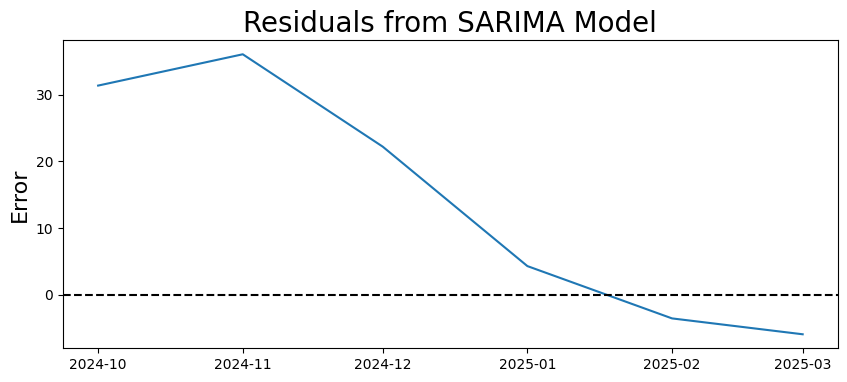

In [92]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

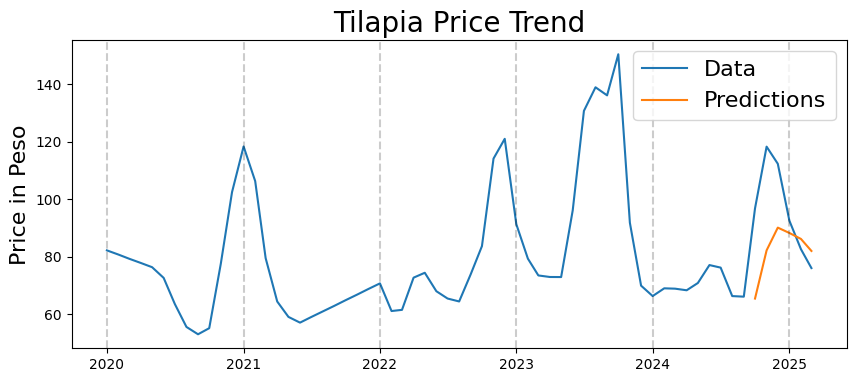

In [93]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [94]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data['mp_price'], order=my_order, seasonal_order=my_seasonal_order)

    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/home/meg/jupyter_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_63204/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/meg/jupyter_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_63204/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_63204/2302120164.py:9: FutureWarning: Calling float on a single element Serie

In [95]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

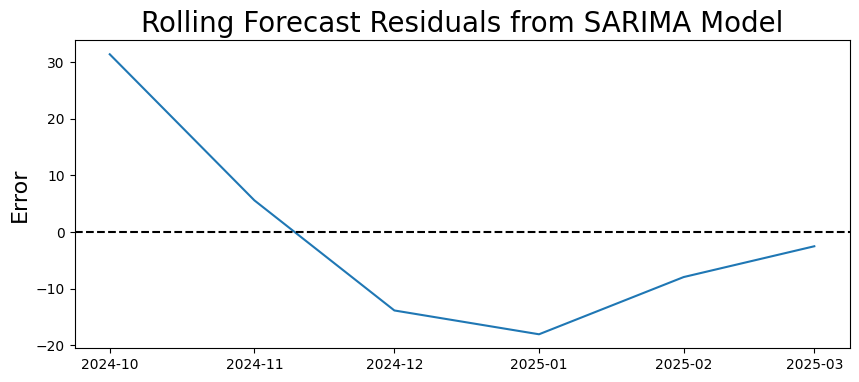

In [96]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

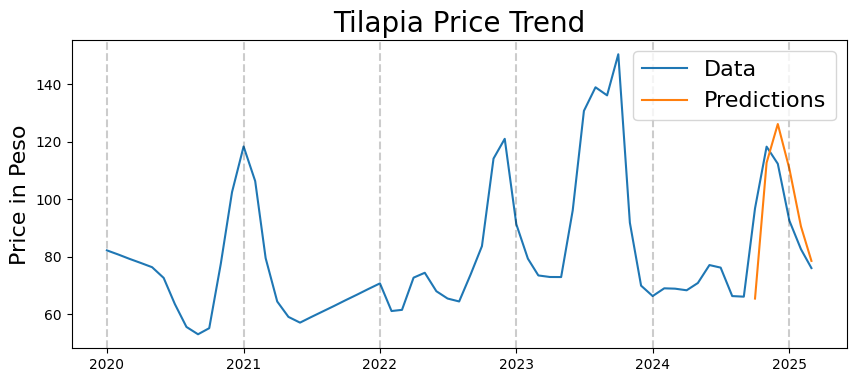

In [97]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [98]:
import numpy as np

In [99]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.1363


In [100]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 16.336205797635614


## Future Predictions (2025)

# eefe 